In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from catboost import CatBoostClassifier


In [2]:
# Read train.csv file into a DataFrame
df_credit = pd.read_csv('./step_2_modified_df_credit_train.csv')

#filter for january only
df_january = df_credit[df_credit['Month'] == 'January'] # to iognore a specific month

#drop column Month and Name and Customer_ID
df_january = df_january.drop(['Month', 'Name', 'Customer_ID'], axis=1)

#display df
df_january.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9601 entries, 0 to 76315
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       9601 non-null   float64
 1   Occupation                9601 non-null   object 
 2   Monthly_Inhand_Salary     8186 non-null   float64
 3   Num_Bank_Accounts         9601 non-null   int64  
 4   Num_Credit_Card           9601 non-null   int64  
 5   Interest_Rate             9601 non-null   int64  
 6   Num_of_Loan               9224 non-null   float64
 7   Delay_from_due_date       9601 non-null   int64  
 8   Num_of_Delayed_Payment    9532 non-null   float64
 9   Changed_Credit_Limit      9415 non-null   float64
 10  Num_Credit_Inquiries      9601 non-null   float64
 11  Credit_Mix                9601 non-null   object 
 12  Outstanding_Debt          9601 non-null   float64
 13  Credit_Utilization_Ratio  9601 non-null   float64
 14  Payment_of_M

In [3]:
df_january.columns



Index(['Age', 'Occupation', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Payment_of_Min_Amount',
       'Total_EMI_per_month', 'Amount_invested_monthly', 'Payment_Behaviour',
       'Monthly_Balance', 'Credit_Score'],
      dtype='object')

In [4]:
# Initialize empty lists for numeric columns (int, int64, float, float64) and object columns
numeric_columns = []
object_columns = []

# Loop over the DataFrame's columns and categorize them based on data type
for column, dtype in df_january.dtypes.items():
    # Check if the data type of the current column is numeric (integer or float)
    if dtype in ['int', 'int64', 'float', 'float64']:
        numeric_columns.append(column)
    # Else, if the column is of object type
    elif dtype == 'object':
        object_columns.append(column)

# Now you have two lists: one with the names of the numeric columns and another with object columns
print("Numeric columns:", numeric_columns)
print("Object columns:", object_columns)


Numeric columns: ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
Object columns: ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour', 'Credit_Score']


In [5]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Assuming 'Credit_Score' is in the original df_january DataFrame before the split
# Fit and transform the 'Credit_Score' column to encode it
df_january['Credit_Score_Encoded'] = label_encoder.fit_transform(df_january['Credit_Score'])




In [6]:
# Now, you can set up your features (X) and target (y) for model training
X = df_january.drop(['Credit_Score','Credit_Score_Encoded'], axis=1)  # Drop the original non-encoded column
y = df_january['Credit_Score_Encoded']  # Use the encoded column as the target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
 #select columns to inpute
columns_to_impute = ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
                     'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']
#select columns to encode 
columns_to_encode = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

#select columns to scale
columns_to_scale = ['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
                    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance']

In [8]:
# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', MinMaxScaler())]), columns_to_scale),
        ('cat', OneHotEncoder(drop='first'), columns_to_encode)
    ])

# Apply the preprocessing pipeline to your data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


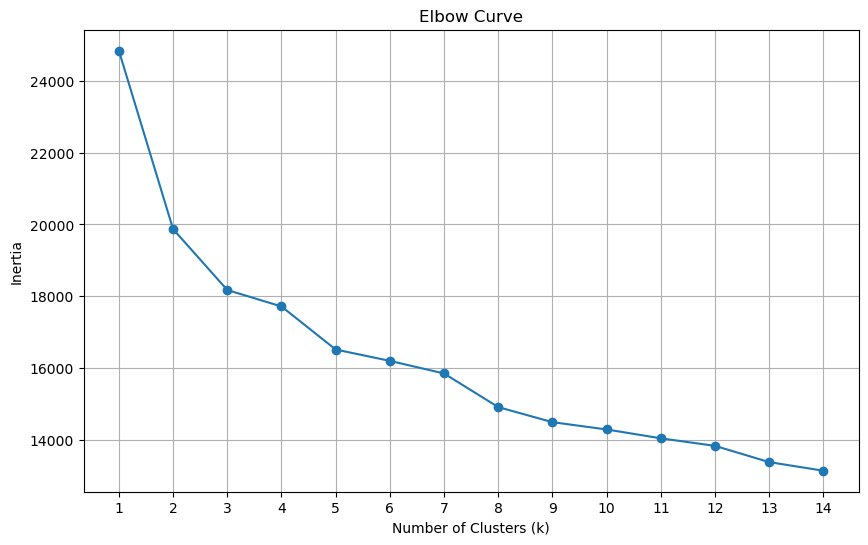

In [9]:
# Range of k values to try
k_values = range(1, 15)

# List to store the inertia for each k value
inertia = []

# Compute inertia for each k value
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_processed)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Curve')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [10]:
# Initialize the KNN model
# You can adjust the number of neighbors (n_neighbors) based on your specific needs
knn = KNeighborsClassifier(n_neighbors=9)

# Train the model using the training sets
knn.fit(X_train_processed, y_train)

# Corrected: Predict the response for the processed test dataset
y_pred = knn.predict(X_test_processed)  # Use X_test_processed for predictions

# Evaluate the model using the correct test labels (y_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.6798542425819886
Confusion Matrix:
 [[195   8  75]
 [ 65 290 192]
 [157 118 821]]
Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.70      0.56       278
           1       0.70      0.53      0.60       547
           2       0.75      0.75      0.75      1096

    accuracy                           0.68      1921
   macro avg       0.64      0.66      0.64      1921
weighted avg       0.70      0.68      0.68      1921



In [11]:
classifiers = [
    ('KNN', KNeighborsClassifier(n_neighbors=8)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=42)),
    ('SVM', SVC(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('AdaBoost', AdaBoostClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('CatBoost', CatBoostClassifier(silent=True, random_state=42))
]

# Initialize a list to store the results
results = []

# Iterate over the classifiers, train them on the processed training set, and evaluate on the processed test set
for name, classifier in classifiers:
    # Train the model using the processed training sets
    classifier.fit(X_train_processed, y_train)
    
    # Predict the response for the processed test dataset
    y_pred = classifier.predict(X_test_processed)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    
    # Append the results
    results.append((name, accuracy, precision, recall, f1))

# Convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1'])

# Sort the DataFrame by F1 score in descending order
results_df_sorted = results_df.sort_values(by='F1', ascending=False)

# Display the sorted DataFrame
results_df_sorted

c:\Users\iabdu\anaconda3\envs\dev\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
4,Gradient Boosting,0.775117,0.734988,0.758330,0.740732
1,Random Forest,0.771473,0.729123,0.763097,0.737682
8,CatBoost,0.764185,0.719894,0.738173,0.724720
3,SVM,0.747527,0.711888,0.761101,0.717286
2,Logistic Regression,0.725664,0.685627,0.703762,0.689636
7,Naive Bayes,0.698074,0.689334,0.781782,0.685983
5,Decision Tree,0.708485,0.664630,0.665352,0.664268
0,KNN,0.681416,0.633954,0.666214,0.642253
6,AdaBoost,0.626236,0.590311,0.558898,0.502752


In [12]:
#select the best model and get confussion matrix
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_processed, y_train)

# Make predictions
y_pred = model.predict(X_test_processed)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[209   6  63]
 [ 45 388 114]
 [120  84 892]]


Accuracy: 77.51%
F1 Score: {'Poor': '64.11%', 'Standard': '75.71%', 'Good': '82.40%'}
Precision Score: {'Poor': '55.88%', 'Standard': '81.17%', 'Good': '83.44%'}
Recall Score: {'Poor': '75.18%', 'Standard': '70.93%', 'Good': '81.39%'}



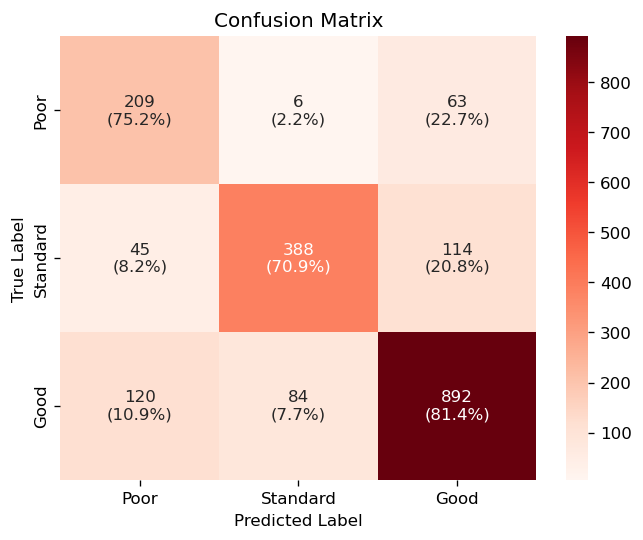

In [13]:
# Assuming y_test and y_hat are already defined and are using 0, 1, 2 for "Poor", "Standard", "Good"
numeric_classes = [0, 1, 2]  # 0 for "Poor", 1 for "Standard", 2 for "Good"

y_hat = model.predict(X_test_processed)
acc_score = accuracy_score(y_test, y_hat)
f1 = f1_score(y_test, y_hat, average=None, labels=numeric_classes)
precision = precision_score(y_test, y_hat, average=None, labels=numeric_classes)
recall = recall_score(y_test, y_hat, average=None, labels=numeric_classes)

# Mapping numeric labels to string for printing
class_mapping = {0: 'Poor', 1: 'Standard', 2: 'Good'}

print(f"Accuracy: {acc_score:.2%}\n\
F1 Score: {dict(zip(class_mapping.values(), map(lambda x: f'{x:.2%}', f1)))}\n\
Precision Score: {dict(zip(class_mapping.values(), map(lambda x: f'{x:.2%}', precision)))}\n\
Recall Score: {dict(zip(class_mapping.values(), map(lambda x: f'{x:.2%}', recall)))}\n\
")

cm = confusion_matrix(y_test, y_hat, labels=numeric_classes)
cm_norm = confusion_matrix(y_test, y_hat, normalize="true", labels=numeric_classes)
annot = np.array([f"{i}\n({g:.1%})" for i, g in zip(cm.flatten(), cm_norm.flatten())])
annot = annot.reshape(cm.shape)

fig = plt.figure(dpi=120)
sns.heatmap(cm, annot=annot, fmt="", cmap="Reds", xticklabels=class_mapping.values(), yticklabels=class_mapping.values())
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [14]:
# Save the sorted results DataFrame to a CSV file
results_df_sorted.to_csv('model_comparison_results.csv', index=False)
